# Lab 2 - Gradient-Based Methods for Mean-Variance Portfolio Optimization

In this lab, we will explore how to use gradient-based optimization algorithms—Gradient Descent (GD), Stochastic Gradient Descent (SGD), and Adam—to determine optimal portfolio weights in a mean-variance framework. We will compare these gradient based approaches with an analytical least squares optimization algorithm from the Scipy library that has been tradionally used to solve these kinds of problems. 

The objective of this lab is for you to understand how to compute optimal portfolio weights using optimization algorithms in machine learning when an investor has an option to invest in more than one asset class. 


##  Mean-Variance Portfolio Optimization - Problem Formulation

1. **Data**: You are provided historical returns for three different asset classes (stocks, bonds and housing). Stock returns are given by S&P composite returns, bond returns by 10 year US Treasury Bills and housing is historical house price index. All data have been retrieved from Robert Shiller's website. All returns are in real terms and span the historical time period 1980-2015 in an annual frequency.
   

4. **Model Assumptions**:
Let $\mathbf{R}_t \in \mathbb{R}^N$ be the return vector at time $t$ for $N$ assets.
- Let $\mu \in \mathbb{R}^N$ be the estimated mean returns vector (annual).
- Let $\Sigma \in \mathbb{R}^{N \times N}$ be the estimated covariance matrix of returns.
3. **Portfolio Return and Variance**:
- Portfolio weights: $\mathbf{w} \in \mathbb{R}^N$, where $\sum_{i=1}^N w_i=1$ (and often $w_i \geq 0$ ).
- Expected portfolio return:

$$
\mu_p=\mathbf{w}^T \mu
$$

- **Portfolio variance**:

$$
\sigma_p^2=\mathbf{w}^T \Sigma \mathbf{w}
$$

4. **Optimization Objective**: The standard portfolio optimization approach is to minimize variance for a given target return or maximize the Sharpe ratio (the excess return over the standard deviation, a return-risk tradeoff measure). For instance, the classic mean-variance formulation can be:

$$
\begin{aligned}
& \qquad \min _{\mathbf{w}} \frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w}-\lambda \mathbf{w}^T \mu \\
& \text { subject to } \sum_{i=1}^N w_i=1 \text { and } w_i \geq 0
\end{aligned}
$$

The first constraint ensures that all the weights sum to 1 (we cannot invest in any other asset class). The second constraint $w_i \geq 0$ means that no short selling is allowed. 

- $\lambda$ is a risk-aversion parameter.
- The $\frac{1}{2}$ is often included for computational convenience (since the derivative of $\frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w}$ is $\Sigma \mathrm{w})$.

**Our objective is to compute the portfolio weights $\mathbf{w} = (w_{Stock}, w_{Bond}, w_{Housing})$.** 

**We would like to answer this question: How should an investor allocate their wealth between stocks, bonds and housing so that the portfolio risk is minimized for a given portfolio return?**


## Gradient Computation

All of the optimization algorithms rely on the us of gradient to minimize the objective function. The gradient is the derivative of
the objective function with respect to the weight vector $\mathbf{w}$.


1. Gradient of the objective (ignoring constraints for the moment):

$$
\nabla_{\mathbf{w}}\left(\frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w}-\lambda \mathbf{w}^T \mu\right)=\Sigma \mathbf{w}-\lambda \mu .
$$

2. Handling constraints:
- Equality constraint $\sum_i w_i=1$ can be enforced via a Lagrange multiplier or by projecting $\mathbf{w}$ onto the simplex after each gradient step.
- Non-negativity constraint $w_i \geq 0$ can be handled similarly by projection or by reparameterizing $\mathbf{w}$.

In [ ]:
import pandas as pd 
import numpy as np 

In [2]:
# load csv data 
df = pd.read_csv("annual_returns.csv")

# Display the first few rows to check if the formatting is now correct
df.head()


,Year,real_return_spcomposite,real_return_10yearbonds,house_price_index
0,1890,0.059988,0.038415,100.000000
1,1891,0.092219,0.040001,88.011791
2,1892,0.074935,0.025941,95.421736
3,1893,0.075183,0.026092,92.297385
4,1894,0.069351,0.012677,123.980483


- The first column is the year 
- the second column reports the real returns of S&P composite index
- the third column reports the real returns of 10 year Treasury Bonds 
- and the final column reports the real house price index.

We will first create the returns from the house price index by taking the log difference of prices. This creates a missing data in the first year (1890) so we drop this first row and work with the rest of the dataset. 

In [3]:
# Compute real house price returns using simple
df["real_return_house"] = np.log(df["house_price_index"]).diff()
df 

,Year,real_return_spcomposite,real_return_10yearbonds,house_price_index,real_return_house
0,1890,0.059988,0.038415,100.000000,NaN
1,1891,0.092219,0.040001,88.011791,-0.127699
2,1892,0.074935,0.025941,95.421736,0.080836
3,1893,0.075183,0.026092,92.297385,-0.033291
4,1894,0.069351,0.012677,123.980483,0.295108
...,...,...,...,...,...
121,2011,0.129860,0.013662,132.460211,-0.069268
122,2012,0.109007,-0.014205,131.384298,-0.008156
123,2013,0.091468,-0.018853,141.912709,0.077086
124,2014,0.097493,-0.018995,148.840761,0.047665


In [4]:
# Remove the first row as it contains NaN due to the log difference computation
df = df.dropna().reset_index(drop=True)

# Drop the original house price index column as it is no longer needed
df = df.drop(columns=["house_price_index"])

df.head()

,Year,real_return_spcomposite,real_return_10yearbonds,real_return_house
0,1891,0.092219,0.040001,-0.127699
1,1892,0.074935,0.025941,0.080836
2,1893,0.075183,0.026092,-0.033291
3,1894,0.069351,0.012677,0.295108
4,1895,0.093011,0.013040,-0.054068


We are optimizing the mean-variance portfolio using historical returns for stocks, bonds, and house prices. The objective function to minimize is:

$$
\min _{\mathbf{w}} \frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w}-\lambda \mathbf{w}^T \mu
$$

subject to:
- Sum constraint: $\sum_{i=1}^N w_i=1$
- No short selling: $w_i \geq 0$ (weights must be non-negative)
where:
- $\mathbf{w}=\left[w_1, w_2, w_3\right]$ are portfolio weights for stocks, bonds, and house price returns.
- $\mu$ is the vector of mean returns.
- $\Sigma$ is the covariance matrix of returns.
- $\lambda$ is a risk-aversion parameter (higher $\lambda$ emphasizes return maximization).



## Compute Mean and Variance of the Portfolio

We will first compute $\mu$ and $\Sigma$ from the historical data. 

In [5]:
# Compute mean returns (mu) and covariance matrix (Sigma)
returns_data = df[["real_return_spcomposite", "real_return_10yearbonds", "real_return_house"]]
mu = returns_data.mean().values  # Mean vector of returns
Sigma = returns_data.cov().values  # Covariance matrix of returns

# Display computed values
mu, Sigma


(array([0.06753205, 0.01766245, 0.00352774]),
 array([[ 0.00273962,  0.00064688, -0.00033854],
        [ 0.00064688,  0.00111236, -0.00011426],
        [-0.00033854, -0.00011426,  0.00462633]]))

The mean returns for stocks, bonds and housing are 6.75%, 1.7% and 0.35% respectively. The average returns for stocks is much higher than bonds or housing. The actual returns for housing is much higher than those reported here, consider this as a heavily biased version of the original data. 

### Set Optimization Parameters

Let's define the number of assets and risk aversion parameter for the problem. This is quite a simple portfolio optimization model in the sense that we have only three assets. 

In [6]:
# Define the optimization problem parameters
num_assets = len(mu)
lambda_risk_aversion = 0.5  # Chosen arbitrarily for now

In [7]:
num_assets, lambda_risk_aversion

(3, 0.5)

### Objective and Gradient Functions 

We will first create two functions that compute the objective and the gradient of the objective function. 

In [8]:
# Define the objective function
def objective_function(w, mu, Sigma, lambda_risk):
    """
    Compute the mean-variance objective function value.
    
    Parameters:
    w : array-like, shape (N,)
        Portfolio weights.
    mu : array-like, shape (N,)
        Mean returns vector.
    Sigma : array-like, shape (N, N)
        Covariance matrix.
    lambda_risk : float
        Risk aversion parameter.
    
    Returns:
    Objective function value.
    """
    return 0.5 * np.dot(w.T, np.dot(Sigma, w)) - lambda_risk * np.dot(w.T, mu)

# Define the gradient of the objective function
def gradient(w, mu, Sigma, lambda_risk):
    """
    Compute the gradient of the objective function.
    
    Parameters:
    w : array-like, shape (N,)
        Portfolio weights.
    mu : array-like, shape (N,)
        Mean returns vector.
    Sigma : array-like, shape (N, N)
        Covariance matrix.
    lambda_risk : float
        Risk aversion parameter.
    
    Returns:
    Gradient vector.
    """
    return np.dot(Sigma, w) - lambda_risk * mu


## Gradient Descent

We will start with the simple Gradient Descent Algorithm. The algorithm is described below:

- **Idea**: Iteratively update the portfolio weights using the full gradient of the objective function computed **from all available data**.
- Objective Function:

$$
f(\mathbf{w})=\frac{1}{2} \mathbf{w}^T \Sigma_t \mathbf{w}-\lambda \mathbf{w}^T \mu_t
$$

where:
- $\Sigma_t$ and $\mu_t$ are the covariance matrix and mean returns vector computed using all historical data up to time $t$.
- Gradient Computation:

$$
\nabla f(\mathbf{w})=\Sigma_t \mathbf{w}-\lambda \mu_t
$$

- **Update Equation**:

$$
\mathbf{w}^{(k+1)}=\mathbf{w}^{(k)}-\alpha\left(\Sigma_t \mathbf{w}^{(k)}-\lambda \mu_t\right)
$$

where $\alpha$ is the learning rate.

Key Points:
- Uses all available data at each iteration.
- Convergence depends on the proper choice of the learning rate $\alpha$.
- Requires projecting $\mathbf{w}$ to satisfy the constraints (e.g., non-negativity and $\sum_i w_i=1$ ).




In [9]:
# Gradient Descent Implementation
def gradient_descent(mu, Sigma, lambda_risk, learning_rate=1e-4, max_iters=5000, tol=1e-8):
    N = len(mu)
    w = np.ones(N) / N  # start with equal weights
    for i in range(max_iters):
        grad = gradient(w, mu, Sigma, lambda_risk)
        w = w - learning_rate * grad
        # Projection step: force non-negativity and sum-to-one constraint
        w = np.maximum(w, 0)
        w = w / np.sum(w)
        if np.linalg.norm(grad) < tol:
            break
    return w


In [10]:
# Run gradient descent optimization
optimal_w_gd = gradient_descent(mu, Sigma, lambda_risk_aversion)

# Display the optimal weights from Gradient Descent
optimal_w_gd

array([0.34270317, 0.33060098, 0.32669585])

The Gradient Descent algorithm imposes equal weights for all three assets. 

### Stochastic Gradient Descent

- **Idea**: Updates the portfolio weights using a **random subset (mini-batch) of the assets** (or data points) instead of the full dataset.
- Modified Gradient Estimation:

$$
\nabla f_{\operatorname{mini}-\operatorname{batch}}(\mathbf{w}) \approx \Sigma_{\operatorname{mini}} \mathbf{w}_{\operatorname{mini}}-\lambda \mu_{\operatorname{mini}}
$$

where the subscript "mini" indicates computation on a randomly selected subset of indices.
- Update Equation:

$$
\mathbf{w}^{(k+1)}=\mathbf{w}^{(k)}-\alpha \nabla f_{\text {mini-batch }}\left(\mathbf{w}^{(k)}\right)
$$

Key Points:
- Introduces randomness, which can help avoid local minima.
- Often faster per iteration for large datasets but can be noisier.
- Also requires projection to enforce constraints.

**NOTE: In this problem, we have only 3 assets. So, this is not an example where Gradient Descent will perform worse than the Stochastic Gradient Descent. In larger datasets, with a lot of assets, SGD should perform better**


In [ ]:
# Stochastic Gradient Descent (SGD) Implementation
def stochastic_gradient_descent(mu, Sigma, lambda_risk, learning_rate=0.000001, max_iters=1000, batch_size=1):
    """
    Perform stochastic gradient descent optimization to find optimal portfolio weights.

    Parameters:
    mu : array-like, shape (N,)
        Mean returns vector.
    Sigma : array-like, shape (N, N)
        Covariance matrix.
    lambda_risk : float
        Risk aversion parameter.
    learning_rate : float, optional
        Step size for gradient updates.
    max_iters : int, optional
        Maximum number of iterations.
    batch_size : int, optional
        Number of elements used in each update.

    Returns:
    array-like : Optimal portfolio weights.
    """
    # Initialize weights equally
    w = np.array([1/num_assets] * num_assets)
    
    for i in range(max_iters):
        # Select a random batch of assets
        indices = np.random.choice(num_assets, batch_size, replace=False)
        grad = np.dot(Sigma[indices][:, indices], w[indices]) - lambda_risk * mu[indices]

        # Update weights only for the selected indices
        w[indices] -= learning_rate * grad
        
        # Enforce constraints 
        w = np.maximum(w, 0)
        w /= np.sum(w)

    return w

# Run SGD optimization
optimal_w_sgd = stochastic_gradient_descent(mu, Sigma, lambda_risk_aversion)

# Display the optimal weights from Stochastic Gradient Descent
optimal_w_sgd


array([0.33334023, 0.33333133, 0.33332844])

Stochastic Gradient Descent Results are similar to GD results, portfolio allocation is uniform. 

In [20]:
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

X = returns_data.values[:-1]      # (T-1, 3)
Y = returns_data.values[1:]       # (T-1, 3)

sgd_reg = MultiOutputRegressor(SGDRegressor(penalty=None, max_iter=1000, tol=1e-3, eta0=0.01))
sgd_reg.fit(X, Y)

# Display the coefficients learned by SGDRegressor
[est.coef_ for est in sgd_reg.estimators_]


[array([ 0.00837391,  0.0020249 , -0.00011475]),
 array([ 2.28715997e-03,  2.23401084e-03, -6.00143178e-05]),
 array([2.37884896e-04, 8.47244788e-05, 3.56086004e-04])]

### Adam 

Adam (Adaptive Moment Estimation) is a very popular optimization algorithm in Neural Networks that builds on GD and SGD ideas.  

Adam stands for Adaptive Moment Estimation. It combines two main ideas:
- Momentum: Instead of using only the current gradient, Adam computes an exponential moving average of past gradients. This helps smooth out noisy updates (like carrying inertia in the direction of descent).
- Adaptive Learning Rates: Adam also calculates an exponential moving average of the squared gradients. This lets the algorithm adjust the learning rate for each parameter individually, taking larger steps for parameters with small historical gradients and smaller steps for those with large gradients.

- Key Components and Equations:
1. Gradient Computation:

$$
g^{(k)}=\nabla f\left(\mathbf{w}^{(k)}\right)=\Sigma \mathbf{w}^{(k)}-\lambda \mu
$$

2. First Moment Estimate (Momentum):

Compute an exponential moving average of the gradients:

$$
m^{(k)}=\beta_1 m^{(k-1)}+\left(1-\beta_1\right) g^{(k)}
$$

- Here, $\beta_1$ is typically set around 0.9.
- In simple words: This averages the past gradients so that the update direction is less erratic.
3. Second Moment Estimate (Adaptive Learning Rate):

Compute an exponential moving average of the squared gradients:

$$
v^{(k)}=\beta_2 v^{(k-1)}+\left(1-\beta_2\right)\left(g^{(k)}\right)^2
$$

- Here, $\beta_2$ is typically set around 0.999 .
- In simple words: This tracks how large the gradients are over time so that if a parameter has a consistently high gradient, its update step will be scaled down.
4. Bias Correction:

Because $\boldsymbol{m}^{(k)}$ and $v^{(k)}$ start at zero, we correct the bias:

$$
\hat{m}^{(k)}=\frac{m^{(k)}}{1-\beta_1^k}, \quad \hat{v}^{(k)}=\frac{v^{(k)}}{1-\beta_2^k}
$$

- In simple words: This adjustment compensates for the fact that the moving averages are biased towards zero in the early steps.

5. Update Equation:

Finally, update the weights:

$$
\mathbf{w}^{(k+1)}=\mathbf{w}^{(k)}-\alpha \frac{\hat{m}^{(k)}}{\sqrt{\hat{v}^{(k)}}+\epsilon}
$$

- $\alpha$ is the learning rate.
- $\epsilon$ is a small constant (e.g., $1 \times 10^{-8}$ ) to prevent division by zero.
- In simple words: The update adjusts the weights by combining the smoothed direction (momentum) and scaling the step size based on the historical magnitude of the gradients (adaptive learning rates).

**Benefits of using Adam**
- Smooth Updates: The momentum helps avoid oscillations and noisy updates, making the optimization process smoother.
- Adaptive Steps: Each parameter’s update is tailored to its historical behavior, often leading to faster and more reliable convergence.
- Robustness: Adam tends to perform well across a variety of problems, making it a popular choice in practice.

In [12]:
# Adam (Adaptive Moment Estimation)
def adam(mu, Sigma, lambda_risk, learning_rate=1e-2, beta1=0.9, beta2=0.999, max_iters=5000, epsilon=1e-8):
    N = len(mu)
    w = np.ones(N) / N  # initialize equally
    m = np.zeros(N)     # first moment vector
    v = np.zeros(N)     # second moment vector
    for t in range(1, max_iters + 1):
        grad = gradient(w, mu, Sigma, lambda_risk)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        w = w - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        # Projection step: enforce non-negativity and normalization
        w = np.maximum(w, 0)
        w = w / np.sum(w)
    return w

In [13]:
# get portfolio weights using Adam 
optimal_w_adam = stochastic_gradient_descent(mu, Sigma, lambda_risk_aversion)

optimal_w_adam 

array([0.33333949, 0.33333158, 0.33332893])

Adam also finds an equally weighted portfolio between the three assets as the optimum. 

### (Approx) Analytical Solution using Scipy Optimize - Sequential Least Squares Programming

- Basic Idea:

A numerical optimization solver that directly minimizes the objective function while **handling constraints explicitly**.
- Objective Function:

$$
\min _{\mathbf{w}} \frac{1}{2} \mathbf{w}^T \Sigma_t \mathbf{w}-\lambda \mathbf{w}^T \mu_t
$$

- Constraints:
- Budget Constraint:

$$
\sum_{i=1}^N w_i=1
$$

- No Short-Selling:

$$
w_i \geq 0 \quad \forall i
$$

Key Points:
- Uses Sequential Quadratic Programming to solve the constrained optimization problem.
- Finds the optimal solution that strictly satisfies the constraints.
- Particularly effective for small- to medium-sized portfolios. 

In [14]:
from scipy.optimize import minimize

# Constraint: sum of weights = 1
def constraint(w):
    return np.sum(w) - 1

# Bounds: No short selling (w >= 0)
bounds = [(0, 1)] * num_assets

# Initial guess (equal allocation)
w_init = np.array([1/num_assets] * num_assets)

# Run optimization using Scipy's minimize function
result = minimize(
    objective_function, 
    w_init, 
    args=(mu, Sigma, lambda_risk_aversion), 
    method='SLSQP', 
    constraints={'type': 'eq', 'fun': constraint}, 
    bounds=bounds
)

# Extract optimal weights
optimal_w_scipy = result.x

# Display optimal weights from Scipy solver
optimal_w_scipy


array([1.00000000e+00, 0.00000000e+00, 3.07046055e-16])

Scipy's constrained optimization algorithm puts all the weight on stocks and very little on either bonds or housing. This result is very different from the other three. 

## Results and Algorithm Comparison

- Scipy’s SLSQP Solver is **more robust in identifying the true optimum** by satisfying the constraints exactly and using second-order-like information through its quadratic approximations. In this case, it found that allocating nearly 100% to stocks minimizes the objective function given the historical data.
- GD, SGD, and Adam, in contrast, converged to an equal-weighted solution because of factors such as **learning rate, projection steps, and the absence of curvature information**. These methods may have been “stuck” in an interior solution due to their update dynamics, especially in a **low-dimensional space where the extreme optimum is at the boundary**.

**Low Dimensional Optimization - 3 Assets**
We assumed only 3 assets in this portfolio optimization problem which heavily favours algorithms like Scipy's least squares programming which is almost analytical in nature. Algorithms like GD, SGD and Adam really shine when there are a lot of data points, when we have a lot of assets. 
- With only three assets, the feasible region (the simplex of weights) is small and any differences in risk and return estimates become very influential.
- Corner Solutions: When one asset (stocks in this case) appears significantly more attractive (for example, much higher return or better risk-adjusted performance), the true global optimum may lie at a corner of the feasible region. Scipy’s SLSQP, which is designed to accurately satisfy the Karush-Kuhn-Tucker (KKT) conditions, can identify these corner solutions where almost all weight is allocated to the best asset.

**Local vs. Global Optima**
- GD, SGD and Adam can get stuck in local minima depending on the initial weights and learning rate.
- Scipy's SLSQP aims to find a global minimum with constraint handling.

**Differences in Solver Approaches**
- Scipy’s SLSQP: This method uses a sequential quadratic programming approach that considers both the objective function and constraints simultaneously. It is very good at navigating the constraints (e.g., non-negativity and sum-to-one) to find the true minimum—even if that minimum lies at the boundary of the feasible region.
- Gradient-Based Methods: While they are conceptually simpler, they often require careful tuning and may be more “local” in nature. In a small, low-dimensional space, if the gradient updates are not sufficiently aggressive or if the projection steps are too “blunt,” these methods might converge to a balanced solution instead of exploring the boundaries where the true optimum might lie.

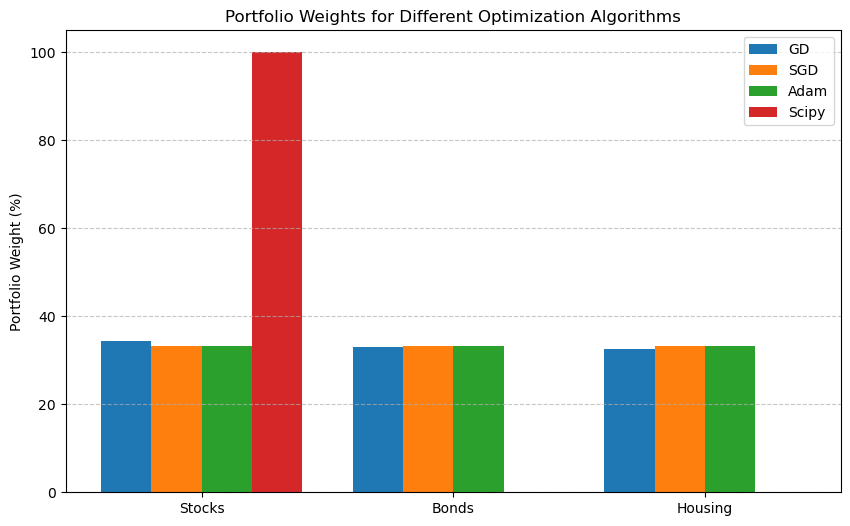

In [15]:
import matplotlib.pyplot as plt 
# Asset labels
labels = ["Stocks", "Bonds", "Housing"]

# Number of asset classes
n_assets = len(labels)
x = np.arange(n_assets)

# Bar width
width = 0.2

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each optimization method with appropriate offsets
ax.bar(x - 1.5*width, optimal_w_gd * 100, width, label="GD")
ax.bar(x - 0.5*width, optimal_w_sgd * 100, width, label="SGD")
ax.bar(x + 0.5*width, optimal_w_adam * 100, width, label="Adam")
ax.bar(x + 1.5*width, optimal_w_scipy * 100, width, label="Scipy")

# Set x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Portfolio Weight (%)")
ax.set_title("Portfolio Weights for Different Optimization Algorithms")
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Homework - Portfolio Rebalancing Extension

In the above approach, we have assumed that portfolio weights are constant across time, that is no portfolio rebalancing which is unrealistic. Using the historical data provided, extend the portfolio optimization algorithm we have done to incorporate annual portfolio rebalancing starting in the year 1950. Meaning, you optimize for the weights after each period (year here).  Specifically, you are required to:
1. Rebalance Portfolio Weights Annually:
- For every year starting from 1950, recompute the mean returns vector $\mu_t$ and covariance matrix $\Sigma_t$ using all available data from the beginning of the dataset up to that year.
- Solve for the optimal portfolio weights $\mathbf{w}_t$ by minimizing the following mean-variance objective function:

$$
\min _{\mathbf{w}_t} f\left(\mathbf{w}_t\right)=\frac{1}{2} \mathbf{w}_t^T \Sigma_t \mathbf{w}_t-\lambda \mathbf{w}_t^T \mu_t
$$

subject to:

$$
\sum_{i=1}^3 w_{i, t}=1 \text { and } w_{i, t} \geq 0 \text { for } i=1,2,3
$$

- Here, $\lambda$ is the risk-aversion parameter, and the three assets correspond to Stocks, Bonds, and Housing.

Hints:

- Rolling Window Estimation: At each rebalancing year $t$, compute the historical mean and covariance matrix using all data from the start of the dataset until year $t$. 
- Rebalancing:The first rebalancing should occur in the year 1950. Before 1950, you can assume that the portfolio is held constant.
- Constraints Handling:Make sure your optimization method enforces that the weights sum to 1 and are non-negative (i.e., no short selling).
- Parameter Tuning: Experiment with learning rates and iteration numbers for GD, SGD, and Adam to ensure convergence. The Scipy solver should automatically handle the constraints.